# What & Why
tbd

# Learnings
tbd

# Python packages setup & data download

This part is copied from the [01-baseline.ipynb](./01-baseline.ipynb)

In [1]:
DO_SUBMIT_TO_KAGGLE = True

In [2]:
USE_LATEST_PIP_PACKAGES = True

In [3]:
import os
is_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if is_kaggle:
    print("Running notebook in kaggle mode")
else:
    print("Running notebook in Paperspace mode")

Running notebook in Paperspace mode


In [4]:
# install Jeremy's fastkaggle package with helpers for Kaggle API
try:
    import fastkaggle
except ModuleNotFoundError:
    if is_kaggle:
        print("installing fastkaggle into system folder on Kaggle")
        !pip install -q fastkaggle
    else:
        print("installing fastkaggle into user (/root/.local/) folder on Paperspace")
        # we are installing into local folder
        !pip install --user -q fastkaggle

from fastkaggle import setup_comp, push_notebook

In [5]:
# Jeremy's philosophy is to always work on latest versions of all packages 
# and don't bother with creating and tracking Python environments with the fixed set of packages
# I still like to have full replica of the env, so plan to add it as a fallback
if not is_kaggle:
    if USE_LATEST_PIP_PACKAGES:
        !pip install --user -Uqq timm==0.6.13 huggingface_hub fastai pynvml
    else:
        !pip install --user  --no-cache-dir -r ../requirements.txt

## Get competition data

In [6]:
# setup_comp downloads competition dataset archive into the current folder and extracts into subfolder
# it also pip-installs libraries when if we are on Kaggle
COMPETITION_NAME = 'paddy-disease-classification'

path = setup_comp(COMPETITION_NAME, install='timm huggingface_hub fastai')

In [7]:
import pandas as pd

In [8]:
# import fastai only after we updated all packages on Kaggle or locally
from fastai.vision.all import *
from fastcore.parallel import *
#from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback
set_seed(42)

In [9]:
path.ls()

(#4) [Path('paddy-disease-classification/sample_submission.csv'),Path('paddy-disease-classification/test_images'),Path('paddy-disease-classification/train_images'),Path('paddy-disease-classification/train.csv')]

# Quick look at data

In [10]:
train_path = path / "train_images"

In [11]:
train_files = get_image_files(train_path)

File:  paddy-disease-classification/train_images/tungro/100723.jpg
Size:  (480, 640)


<AxesSubplot:>

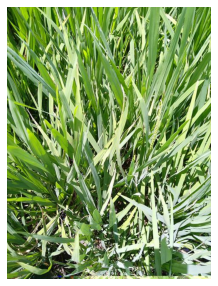

In [12]:
# show single file
idx = 2002
img = PILImage.create(train_files[idx])
print("File: ", train_files[idx])
print("Size: ", img.size)
img.show()

In [13]:
subm_files = get_image_files(path / 'test_images').sorted()

# Helpers to train the model

In [14]:
DEFAULT_BATCH_SIZE = 64
DEFAULT_LR = 0.005
DEFAULT_SEED = 68

In [15]:
def train(arch, size, item_transforms, accum=1, n_epochs=1, 
          logical_batch_size=DEFAULT_BATCH_SIZE, 
          seed=DEFAULT_SEED, 
          lr=DEFAULT_LR, 
          path=None,
          with_early_stopping=True):
    dls = ImageDataLoaders.from_folder(
        train_path, 
        valid_pct=0.2, 
        seed=seed, 
        item_tfms=item_transforms,
        batch_tfms=aug_transforms(size=size, min_scale=0.75),
        bs = logical_batch_size // accum
    )
    callbacks = []
    if accum:
        callbacks.append(GradientAccumulation(logical_batch_size))
    if with_early_stopping:
        print("running with early stopping")
        # EarlyStopping based on validation set
        callbacks.append(EarlyStoppingCallback(monitor='valid_loss', patience=5))
        # Save the best model based on validation error rate
        callbacks.append(SaveModelCallback(monitor='error_rate', fname='best_model'))
    
    learn = vision_learner(dls, arch, metrics=error_rate, cbs=callbacks, path=path).to_fp16()
    learn.fine_tune(n_epochs, lr)
    return learn

# Train and report validation

In [16]:
# save all config params to post them in kaggle description
#model_name = "convnext_large_in22k"
#input_size = (320,240)
#item_transform = Resize((640,480))
#n_epochs = 36
#accum = 2

model_name = "vit_large_patch16_224"
input_size = 224
item_transform = Resize((640,480))
n_epochs = 36
accum = 2
with_early_stopping = True

# small test
# model_name = "convnext_small_in22k"
# input_size = 32
# item_transform = Resize(256)
# n_epochs = 5
# accum = 1

In [17]:
ts_suffix = datetime.now().strftime("%Y-%m-%dT%H%M%S")
export_path = Path("models") / model_name / ts_suffix
export_path.mkdir(parents=True, exist_ok=True)
print("Model export dir ", export_path)

Model export dir  models/vit_large_patch16_224/2024-09-10T212209


In [18]:
%%time
model = train(model_name, input_size, item_transform, 
              accum=accum, 
              n_epochs=n_epochs, 
              path=export_path, 
              with_early_stopping=with_early_stopping)

running with early stopping


epoch,train_loss,valid_loss,error_rate,time
0,0.978469,0.563846,0.171552,02:06


Better model found at epoch 0 with error_rate value: 0.1715521365404129.


epoch,train_loss,valid_loss,error_rate,time
0,0.442050,0.228441,0.073042,02:34
1,0.278110,0.171075,0.047573,02:34
2,0.223027,0.184002,0.046132,02:34
3,0.198849,0.178588,0.049015,02:34
4,0.177704,0.159484,0.037963,02:35
5,0.161062,0.219700,0.061028,02:35
6,0.166061,0.169046,0.042768,02:35
7,0.163680,0.156210,0.040846,02:35
8,0.161922,0.163669,0.039404,02:36
9,0.152932,0.147325,0.040846,02:35


Better model found at epoch 0 with error_rate value: 0.07304180413484573.
Better model found at epoch 1 with error_rate value: 0.047573283314704895.
Better model found at epoch 2 with error_rate value: 0.046131666749715805.
Better model found at epoch 4 with error_rate value: 0.03796251863241196.
Better model found at epoch 11 with error_rate value: 0.03700144216418266.
Better model found at epoch 12 with error_rate value: 0.035079289227724075.
Better model found at epoch 13 with error_rate value: 0.025949062779545784.
Better model found at epoch 20 with error_rate value: 0.024026909843087196.
Better model found at epoch 21 with error_rate value: 0.021624218672513962.
Better model found at epoch 22 with error_rate value: 0.02018260397017002.
Better model found at epoch 23 with error_rate value: 0.01874098926782608.
Better model found at epoch 24 with error_rate value: 0.018260451033711433.
Better model found at epoch 25 with error_rate value: 0.016818836331367493.
Better model found at

<AxesSubplot:title={'center':'learning curve'}, xlabel='steps', ylabel='loss'>

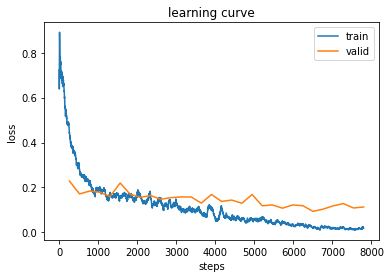

In [19]:
model.recorder.plot_loss(skip_start=0, with_valid=True)

In [20]:
# get validation data loader from leraner 
# It uses 20% of train data as specified in `train` function above
validation_dl = model.dls.valid

In [21]:
# preds is a tensor of probabilites with each row sum to 1
# targs is a vector with category idex
preds, targs = model.get_preds(dl=validation_dl)
print("Error rate on validation set", error_rate(preds, targs))

Error rate on validation set TensorBase(0.0154)


In [22]:
tta_preds, _ = model.tta(dl=validation_dl)
print("Error rate on validation set with TTA", error_rate(tta_preds, targs))

Error rate on validation set with TTA TensorBase(0.0149)


### Export model and predictions

In [23]:
model.export("model.pckl")

In [24]:
config = {
    "model_name": model_name,
    "input_size": input_size,
    "item_transform": item_transform,
    "n_epochs": n_epochs,
    "accum": accum,
}
save_pickle(export_path/"config.pckl", config)

In [25]:
# sanity check -> reload model and run predictions
if False:
    model = load_learner(export_path/"model.pckl", cpu=False)
    reloaded_preds, _ = model.get_preds(dl=validation_dl)
    print("Error rate on validation set", error_rate(reloaded_preds, targs))

## Generate scores for submission

In [26]:
import torch

In [27]:
test_files = get_image_files( path / 'test_images').sorted()
test_dl = model.dls.test_dl(test_files)

In [28]:
predicted_probs,_ = model.tta(dl=test_dl)

In [29]:
torch.save(predicted_probs, export_path / "predicted_probs.pt")

In [30]:
predicted_idxs = predicted_probs.argmax(dim=1)

In [31]:
category_names = model.dls.vocab
category_names

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [32]:
subm_df = pd.read_csv(path / 'sample_submission.csv')

In [33]:
subm_df['label'] = category_names[predicted_idxs.numpy()]

In [34]:
assert subm_df["label"].isnull().sum() == 0

In [35]:
subm_df.to_csv('subm_p4.csv', index=False)
!head subm_p4.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


In [36]:
if not is_kaggle and DO_SUBMIT_TO_KAGGLE:
    from kaggle import api
    config_line = f'part4: {model_name} i_size:{item_transform.size} b_size:{input_size} n_epocs:{n_epochs} accum:{accum}'
    config_line += f"\n path:{export_path}"
    api.competition_submit_cli('subm_p4.csv', config_line, COMPETITION_NAME)
    with open(export_path / "is_submitted", "wt") as fh:
        fh.write("yes")

100%|██████████| 70.5k/70.5k [00:00<00:00, 231kB/s]
